<a href="https://colab.research.google.com/github/victorhss21/Estudos_CD/blob/main/Matching_Score_CL_with_KNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 00. Gerando conjunto de dados sintético

In [1]:
import pandas as pd
import numpy as np
import random

# Configuração para reprodutibilidade
np.random.seed(42)

def gerar_base_sintetica(n_registros=500000):
    print(f"Iniciando geração de {n_registros} registros...")

    # --- 1. Geração de CNPJs Únicos ---
    # Geramos números aleatórios únicos para garantir chave primária
    # Intervalo suficiente para cobrir n_registros
    print("Gerando CNPJs...")
    raizes = np.random.choice(range(10000000, 99999999), size=n_registros, replace=False)
    cnpjs = [f"{r}" for r in raizes]

    # --- 2. Definição de Categorias e Distribuições ---

    # Portes (Segmento de Cliente)
    portes = ['MEI', 'LOWER', 'MIDDLE', 'UPPER']
    p_portes = [0.40, 0.30, 0.20, 0.10] # Maioria é pequena empresa

    # Ramos
    ramos = ['Varejo', 'Comercio', 'Educacao', 'Tecnologia']

    # Modelos
    modelos = ['B2C', 'B2B', 'B2G']

    # Estados (Peso aproximado por relevância econômica)
    estados = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'PE', 'CE', 'GO', 'ES', 'MT', 'MS', 'DF']
    p_estados = [0.35, 0.10, 0.10, 0.08, 0.07, 0.05, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02]
    # Normalizar para garantir soma 1.0
    p_estados = np.array(p_estados) / np.sum(p_estados)

    # --- 3. Atribuição Vetorizada das Características Básicas ---
    print("Atribuindo características...")

    df = pd.DataFrame({
        'cnpj': cnpjs,
        'cnpj_raiz': raizes,
        'porte': np.random.choice(portes, n_registros, p=p_portes),
        'ramo': np.random.choice(ramos, n_registros),
        'modelo_operacao': np.random.choice(modelos, n_registros, p=[0.5, 0.4, 0.1]),
        'estado': np.random.choice(estados, n_registros, p=p_estados),
        # Definindo 'segmento_analise' (Novo vs Outro)
        # Premissa: 'Novo' segmento tende a ser mais Tech e Varejo Digital
        'segmento_analise': np.random.choice(['novo', 'outro'], n_registros, p=[0.2, 0.8])
    })

    # --- 4. Geração Coerente de Valores Numéricos (Lógica de Negócio) ---
    print("Calculando métricas financeiras coerentes...")

    # Função auxiliar para gerar valores baseados no porte
    def get_vol_recebimento(porte):
        if porte == 'MEI': return np.random.uniform(1000, 6750)
        elif porte == 'LOWER': return np.random.uniform(5000, 50000)
        elif porte == 'MIDDLE': return np.random.uniform(40000, 300000)
        else: return np.random.uniform(200000, 800000) # UPPER

    # Vetorização usando numpy select/piecewise para performance
    conditions_vol = [
        df['porte'] == 'MEI',
        df['porte'] == 'LOWER',
        df['porte'] == 'MIDDLE',
        df['porte'] == 'UPPER'
    ]

    # Gerando vetores aleatórios para cada condição
    vals_mei = np.random.uniform(1000, 6750, n_registros)
    vals_lower = np.random.uniform(5000, 50000, n_registros)
    vals_middle = np.random.uniform(40000, 300000, n_registros)
    vals_upper = np.random.uniform(200000, 800000, n_registros)

    df['vol_recebimento_total'] = np.select(conditions_vol, [vals_mei, vals_lower, vals_middle, vals_upper])

    # Ajuste fino: Tecnologia e Varejo tendem a faturar um pouco mais dentro da faixa
    mask_boost = df['ramo'].isin(['Tecnologia', 'Varejo'])
    df.loc[mask_boost, 'vol_recebimento_total'] *= np.random.uniform(1.0, 1.2, mask_boost.sum())

    # Garantir teto máximo do enunciado
    df['vol_recebimento_total'] = df['vol_recebimento_total'].clip(1000, 800000)

    # --- 5. Geração de Transações Digitais (Coerência com Ramo e Modelo) ---
    # Base: Quanto maior o faturamento, mais transações, MAS depende do modelo
    # B2C Varejo = Muitas transações pequenas
    # B2B Consultoria = Poucas transações grandes

    base_transacoes = np.random.randint(5, 1000, n_registros)

    # Fatores multiplicadores
    fator_modelo = np.select(
        [df['modelo_operacao'] == 'B2C', df['modelo_operacao'] == 'B2B', df['modelo_operacao'] == 'B2G'],
        [1.5, 0.6, 0.4] # B2C transaciona mais vezes
    )

    fator_ramo = np.select(
        [df['ramo'] == 'Tecnologia', df['ramo'] == 'Varejo', df['ramo'] == 'Educacao'],
        [1.8, 1.5, 0.8], default=1.0 # Tech e Varejo são mais digitais
    )

    # Aplica fatores
    df['qtd_transacoes_canais_digitais'] = base_transacoes * fator_modelo * fator_ramo

    # Correlação com Faturamento (quem ganha mais, geralmente transaciona mais)
    # Normaliza faturamento (0 a 1) e usa como boost
    norm_fat = (df['vol_recebimento_total'] - 1000) / (800000 - 1000)
    df['qtd_transacoes_canais_digitais'] += (norm_fat * 200)

    # Clip final para respeitar limites do enunciado e converter para int
    df['qtd_transacoes_canais_digitais'] = df['qtd_transacoes_canais_digitais'].clip(5, 1000).astype(int)

    # --- 6. Otimização de Tipos de Dados ---
    print("Otimizando memória...")
    df['cnpj'] = df['cnpj'].astype('string')
    df['cnpj_raiz'] = df['cnpj_raiz'].astype('uint32') # 8 digitos cabe em uint32
    df['porte'] = df['porte'].astype('category')
    df['ramo'] = df['ramo'].astype('category')
    df['modelo_operacao'] = df['modelo_operacao'].astype('category')
    df['estado'] = df['estado'].astype('category')
    df['segmento_analise'] = df['segmento_analise'].astype('category')
    df['qtd_transacoes_canais_digitais'] = df['qtd_transacoes_canais_digitais'].astype('uint16') # max 1000 cabe em uint16
    df['vol_recebimento_total'] = df['vol_recebimento_total'].astype('float32')

    return df

# --- Execução ---
df_final = gerar_base_sintetica(500000)

# Validações Rápidas
print("\n--- Resumo da Base ---")
print(df_final.info())
print("\n--- Amostra dos Dados ---")
print(df_final.head())

print("\n--- Coerência: Média de Faturamento por Porte ---")
print(df_final.groupby('porte', observed=True)['vol_recebimento_total'].mean().sort_values())

print("\n--- Coerência: Média de Transações por Modelo ---")
print(df_final.groupby('modelo_operacao', observed=True)['qtd_transacoes_canais_digitais'].mean().sort_values())

# # Exportar (Opcional)
# df_final.to_parquet('base_clientes_sintetica.parquet')

Iniciando geração de 500000 registros...
Gerando CNPJs...
Atribuindo características...
Calculando métricas financeiras coerentes...
Otimizando memória...

--- Resumo da Base ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   cnpj                            500000 non-null  string  
 1   cnpj_raiz                       500000 non-null  uint32  
 2   porte                           500000 non-null  category
 3   ramo                            500000 non-null  category
 4   modelo_operacao                 500000 non-null  category
 5   estado                          500000 non-null  category
 6   segmento_analise                500000 non-null  category
 7   vol_recebimento_total           500000 non-null  float32 
 8   qtd_transacoes_canais_digitais  500000 non-null  uint16  
dtypes: category(5

## 01. Propensity Score Matching

#### 01.1. Abordagem A: Classificador Probabilístivo + KNN

##### Versão incial (e funcional) do código:

~~~~python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ==============================================================================
# 1. ADAPTAÇÃO DO DATASET GERADO (df_final) PARA O FLUXO DE MATCHING
# ==============================================================================

# Assumindo que 'df_final' já foi gerado pelo código anterior
df = df_final.copy()

# Criar target binário: 1 se 'novo', 0 se 'outro'
df['segmento_novo'] = (df['segmento_analise'] == 'novo').astype(int)

# Simulação da variável de crescimento
np.random.seed(42)
mask_benchmark = df['segmento_novo'] == 0
n_bench = mask_benchmark.sum()
df.loc[mask_benchmark, 'crescimento_anual_real'] = np.random.normal(0.15, 0.05, n_bench)

# ==============================================================================
# 2. PREPARAÇÃO DE FEATURES
# ==============================================================================

cat_features = ['ramo', 'modelo_operacao', 'porte', 'estado']
num_features = ['vol_recebimento_total', 'qtd_transacoes_canais_digitais']

X = df[cat_features + num_features]
y = df['segmento_novo']

# Preprocessor base (será usado para LogReg)
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Preprocessor para Árvores (XGB/LGBM lidam bem com numéricas sem scale, apenas OneHot simples)
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features), # Árvores não precisam de StandardScaler
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# ==============================================================================
# 3. DEFINIÇÃO DOS 3 MODELOS
# ==============================================================================

# Modelo 1: Regressão Logística
model_logreg = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Modelo 2: XGBoost
model_xgboost = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(class_weight='balanced', random_state=42, eval_metric='logloss', # usando 'logloss' intencionalmente dado que ela penalizando predições de probabilidade muito confiantes e erradas, dado nosso propósito de PSM
                                 n_jobs=-1, max_depth=5, learning_rate=0.1, n_estimators=10))
])

# Modelo 3: LightGBM
model_lgbm = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=42, metric='logloss',
                                  n_jobs=-1, max_depth=5, learning_rate=0.1, n_estimators=10))
])

models = {
    'Logistic Regression': model_logreg,
    'XGBoost': model_xgboost,
    'LightGBM': model_lgbm
}

# ==============================================================================
# 4. GERAÇÃO DE SCORES, CALIBRAÇÃO E PLOTAGEM
# ==============================================================================

# Definindo nº splits do CV externo (Predição de Probabilidades)
n_splits_external = 3 # 5

# Definindo nº splits do CV interno (Calibração de Probabilidades)
n_splits_calibration_prob = 3

# Instanciado StratifiedKFold para reliazação de cross validation
cv = StratifiedKFold(n_splits=n_splits_external, shuffle=True, random_state=42)

# Definição do método de calibração das probabilidades com base no tamanho do conjunto de dados
calibration_method = 'isotonic' if ((len(df)/n_splits_external)/n_splits_calibration_prob) > 1000 else 'sigmoid'
print(f"Aplicando calibração via método: {calibration_method.upper()}")

# Dicionário para armazenar scores finais de cada modelo
scores_results = {}

# Configuração dos Subplots: 2 Linhas (Calibração, KDE), 3 Colunas (Modelos)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for i, (name, model) in enumerate(models.items()):
    print(f"Processando {name}...")

    # 1. Calibrar e Prever via Cross-Validation
    calibrated_model_cv = CalibratedClassifierCV(estimator=model, method=calibration_method, cv=n_splits_calibration_prob)
    y_proba_cv = cross_val_predict(calibrated_model_cv, X, y, cv=cv, method='predict_proba', n_jobs=-1)

    # Guardar score
    scores_results[name] = y_proba_cv[:, 1]

    # 2. Plot Reliability Diagram (Linha 0, Coluna i)
    prob_true, prob_pred = calibration_curve(y, scores_results[name], n_bins=10)
    ax_calib = axes[0, i]
    ax_calib.plot([0, 1], [0, 1], "k:", label="Perfeito")
    ax_calib.plot(prob_pred, prob_true, "s-", label=f"{name}")
    ax_calib.set_title(f"Calibração: {name}")
    ax_calib.set_xlabel("Probabilidade Predita")
    ax_calib.set_ylabel("Frequência Real")
    ax_calib.legend()
    ax_calib.grid(True, alpha=0.3)

    # 3. Plot KDE Overlap (Linha 1, Coluna i)
    ax_kde = axes[1, i]
    sns.kdeplot(scores_results[name][y==1], label='Novo (Alvo)', fill=True, alpha=0.3, ax=ax_kde)
    sns.kdeplot(scores_results[name][y==0], label='Outros (Fonte)', fill=True, alpha=0.3, ax=ax_kde)
    ax_kde.set_title(f"Overlap KDE: {name}")
    ax_kde.set_xlabel("Propensity Score")
    ax_kde.legend()

plt.show()

# ==============================================================================
# 5. SELEÇÃO DO MELHOR SCORE E MATCHING COM MELHORIAS 2 E 3
# ==============================================================================

# Escolha qual score usar para o matching final (aqui fixei LightGBM)
df['propensity_score'] = scores_results['LightGBM']

# Converter para Logit
eps = 1e-6
df['propensity_score_clipped'] = df['propensity_score'].clip(eps, 1 - eps)
df['propensity_logit'] = np.log(df['propensity_score_clipped'] / (1 - df['propensity_score_clipped']))

# Preparar DataFrames
df_treatment = df[df['segmento_novo'] == 1].copy().reset_index(drop=True)
df_control = df[df['segmento_novo'] == 0].copy().reset_index(drop=True)

# --- MELHORIA 3: MATCHING COM CALIPER E SEM REPOSIÇÃO ---
# Definir Caliper (0.2 desvios padrão do score Logit)
std_logit = df['propensity_logit'].std()
caliper = 0.2 * std_logit
print(f"Caliper definido (distância máx): {caliper:.4f}")

print("Realizando Matching Sem Reposição com Caliper...")
# Para sem reposição exata em Python de forma eficiente, a melhor estratégia é iterativa ou usar otimização linear.
# Como sklearn NearestNeighbors não suporta 'sem reposição' nativo, implementamos uma heurística gulosa eficiente:
# 1. Encontrar vizinhos candidatos.
# 2. Ordenar por distância.
# 3. Atribuir match se o controle não foi usado ainda.

# Busca inicial de múltiplos vizinhos (ex: 10) para ter candidatos caso o 1º já esteja ocupado
knn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', n_jobs=-1)
knn.fit(df_control[['propensity_logit']])

distances, indices = knn.kneighbors(df_treatment[['propensity_logit']])

# Estruturas para controle de uso
control_used = set()
matches = []

# Iterar sobre os tratamentos (pode ser ordenado por 'dificuldade de match' se desejar refinar, mas aleatório ou sequencial é padrão simples)
# Aqui vamos iterar sequencialmente
for i in range(len(df_treatment)):
    # Candidatos para o tratamento i
    candidates_idx = indices[i]
    candidates_dist = distances[i]

    match_found = None

    for neighbor_idx, dist in zip(candidates_idx, candidates_dist):
        # Verificar Caliper
        if dist > caliper:
            break # Como está ordenado, se passou do caliper, os próximos também passarão

        # Verificar se já foi usado (Sem Reposição)
        if neighbor_idx not in control_used:
            match_found = neighbor_idx
            control_used.add(neighbor_idx)
            break

    if match_found is not None:
        matches.append({
            'idx_treatment': i,
            'idx_control': match_found,
            'distance': dist
        })

# Construir DataFrames Finais dos Matches Válidos
matches_df = pd.DataFrame(matches)
num_discarded = len(df_treatment) - len(matches_df)
print(f"Clientes Novos descartados (sem par válido/disponível): {num_discarded} ({num_discarded/len(df_treatment):.1%})")

df_treatment_matched = df_treatment.iloc[matches_df['idx_treatment']].reset_index(drop=True)
df_control_matched = df_control.iloc[matches_df['idx_control']].reset_index(drop=True)

resultado_matching = pd.DataFrame({
    'CNPJ_Novo': df_treatment_matched['cnpj'].values,
    'Score_Novo': df_treatment_matched['propensity_score'].values,
    'CNPJ_Benchmark': df_control_matched['cnpj'].values,
    'Score_Benchmark': df_control_matched['propensity_score'].values,
    'Meta_Crescimento': df_control_matched['crescimento_anual_real'].values
})

# ==============================================================================
# MELHORIA 2: DIAGNÓSTICO DE BALANCEAMENTO (SMD) - LOVE PLOT
# ==============================================================================

def calculate_smd(df1, df2, columns):
    smd_data = []
    for col in columns:
        mu1, mu2 = df1[col].mean(), df2[col].mean()
        var1, var2 = df1[col].var(), df2[col].var()
        denom = np.sqrt((var1 + var2) / 2)
        if denom == 0: denom = 1e-9
        smd = abs(mu1 - mu2) / denom
        smd_data.append({'Variable': col, 'SMD': smd})
    return pd.DataFrame(smd_data)

# Preparar dados encoded para cálculo SMD
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Fit na base total para consistência
encoder.fit(df[cat_features])
encoded_cols = list(encoder.get_feature_names_out(cat_features))
all_cols_smd = num_features + encoded_cols

# Função auxiliar para transformar
def transform_for_smd(df_input):
    cats = encoder.transform(df_input[cat_features])
    nums = df_input[num_features].values
    data = np.hstack([nums, cats])
    return pd.DataFrame(data, columns=all_cols_smd)

# Antes do Matching (tratamento vs controle total)
df_treat_smd_pre = transform_for_smd(df_treatment)
df_ctrl_smd_pre = transform_for_smd(df_control)
smd_before = calculate_smd(df_treat_smd_pre, df_ctrl_smd_pre, all_cols_smd)

# Depois do Matching (tratamento matched vs controle matched)
df_treat_smd_post = transform_for_smd(df_treatment_matched)
df_ctrl_smd_post = transform_for_smd(df_control_matched)
smd_after = calculate_smd(df_treat_smd_post, df_ctrl_smd_post, all_cols_smd)

# Plot Love Plot
plt.figure(figsize=(10, 8))
plt.plot(smd_before['SMD'], smd_before['Variable'], 'o', label='Antes do Matching', alpha=0.6)
plt.plot(smd_after['SMD'], smd_after['Variable'], 'o', label='Depois do Matching', color='red')
plt.axvline(0.1, color='black', linestyle='--', label='Limite Aceitável (0.1)')
plt.title('Love Plot: Balanceamento de Covariáveis (SMD)')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# 6. ANÁLISE FINAL
# ==============================================================================

print("\n=== Exemplo de Pares Encontrados ===")
print(resultado_matching.head())

media_crescimento_projetada = resultado_matching['Meta_Crescimento'].mean()
print(f"\n=== Resultado da Projeção (LightGBM) ===")
print(f"Média de Crescimento Histórico do Grupo Benchmark: {df_control['crescimento_anual_real'].mean():.2%}")
print(f"Meta de Crescimento Ajustada: {media_crescimento_projetada:.2%}")
~~~~

##### Versão atual (e funcional) do código:

Aplicando calibração via método: ISOTONIC
Processando Logistic Regression...
Processando XGBoost...
Processando LightGBM...


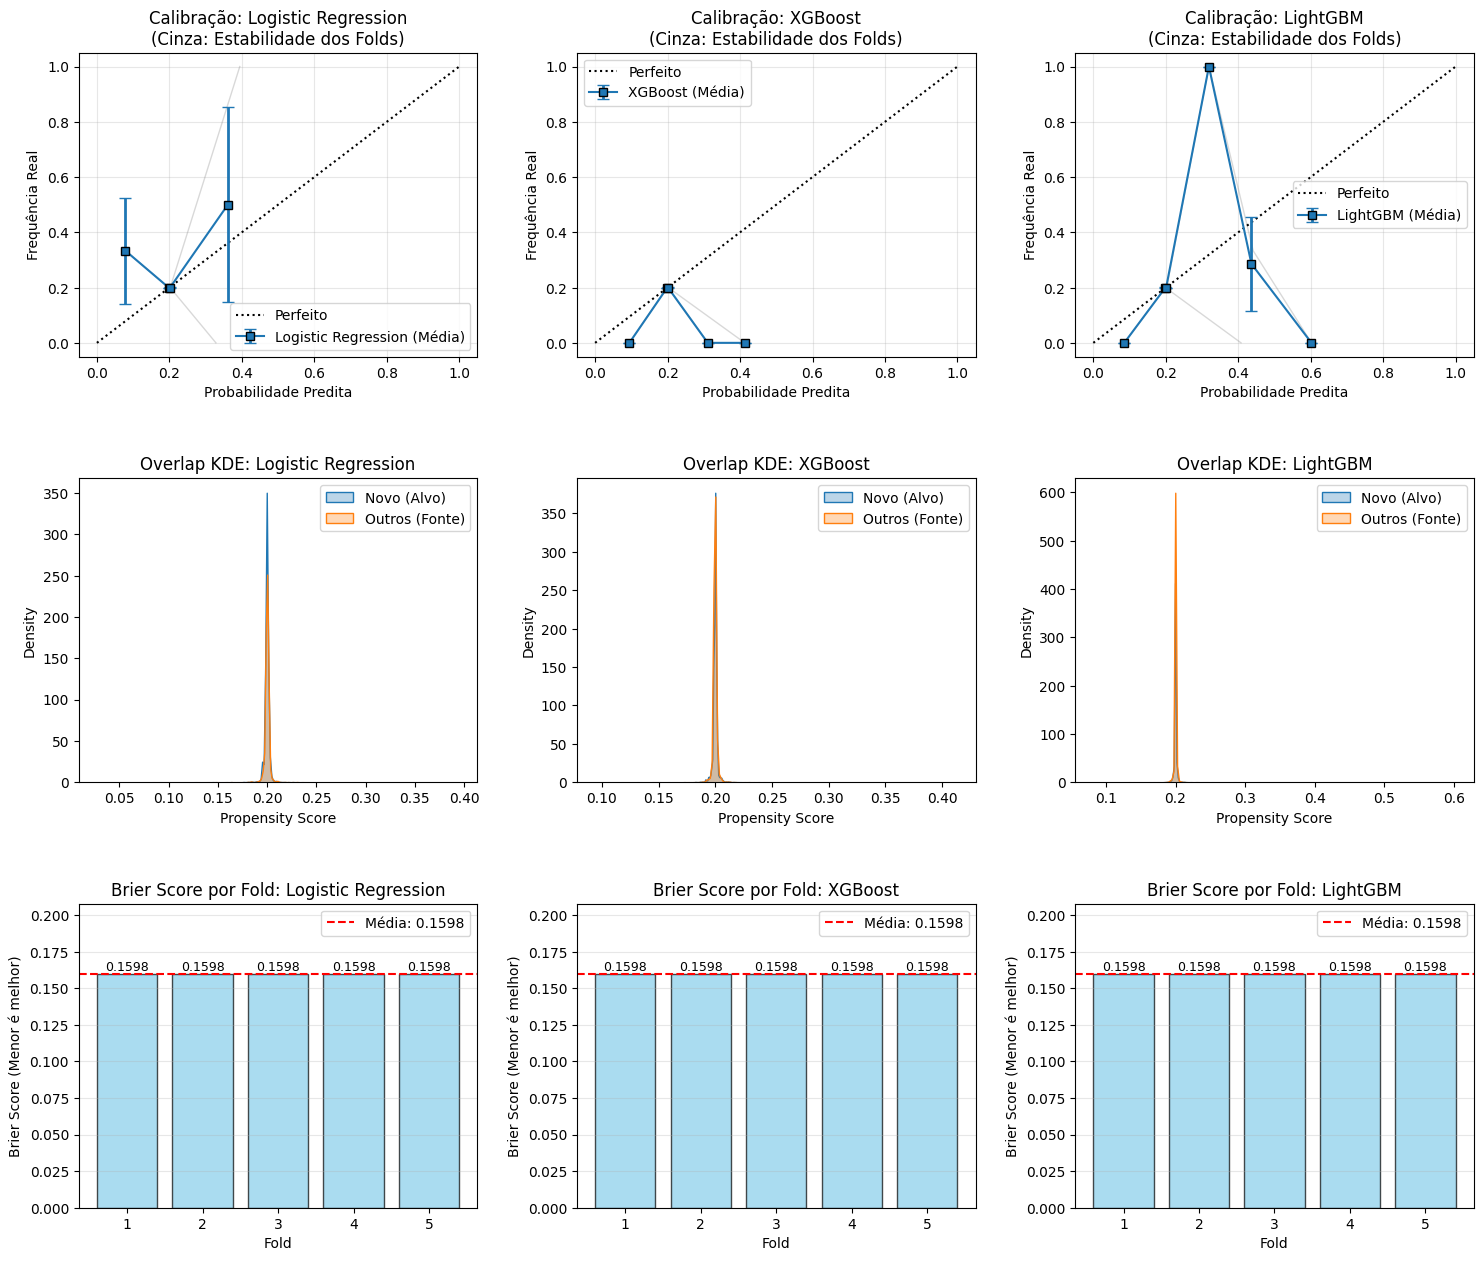

Caliper definido: 0.0030
Descartados: 90445
Resultado Projeção: 14.94%


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Filtrar warnings irrelevantes para manter o log limpo
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ==============================================================================
# 1. ADAPTAÇÃO DO DATASET
# ==============================================================================
df = df_final.copy()
df['segmento_novo'] = (df['segmento_analise'] == 'novo').astype(int)

np.random.seed(42)
mask_benchmark = df['segmento_novo'] == 0
n_bench = mask_benchmark.sum()
df.loc[mask_benchmark, 'crescimento_anual_real'] = np.random.normal(0.15, 0.05, n_bench)

# ==============================================================================
# 2. PREPARAÇÃO DE FEATURES
# ==============================================================================
cat_features = ['ramo', 'modelo_operacao', 'porte', 'estado']
num_features = ['vol_recebimento_total', 'qtd_transacoes_canais_digitais']

X = df[cat_features + num_features]
y = df['segmento_novo']

# Cálculo do scale_pos_weight para XGBoost (substituto correto do class_weight)
n_pos = y.sum()
n_neg = len(y) - n_pos
scale_weight = n_neg / n_pos

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# ==============================================================================
# 3. DEFINIÇÃO DOS MODELOS
# ==============================================================================
model_logreg = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Correção: XGBoost usa scale_pos_weight em vez de class_weight
model_xgboost = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(scale_pos_weight=scale_weight, random_state=42, eval_metric='logloss',
                                 n_jobs=-1, max_depth=5, learning_rate=0.1, n_estimators=10))
])

model_lgbm = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=42, metric='logloss', verbose=-1,
                                  n_jobs=-1, max_depth=5, learning_rate=0.1, n_estimators=10))
])

models = {
    'Logistic Regression': model_logreg,
    'XGBoost': model_xgboost,
    'LightGBM': model_lgbm
}

# ==============================================================================
# 4. GERAÇÃO DE SCORES, CALIBRAÇÃO E PLOTAGEM
# ==============================================================================
n_splits_external = 5
n_splits_calibration_prob = 4
cv = StratifiedKFold(n_splits=n_splits_external, shuffle=True, random_state=42)

calibration_method = 'isotonic' if ((len(df)/n_splits_external)/n_splits_calibration_prob) > 1000 else 'sigmoid'
print(f"Aplicando calibração via método: {calibration_method.upper()}")

scores_results = {}

# Configuração dos Subplots: 3 Linhas (Calibração, KDE, Brier Score)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

for i, (name, model) in enumerate(models.items()):
    print(f"Processando {name}...")

    ax_calib = axes[0, i]
    ax_kde = axes[1, i]
    ax_brier = axes[2, i] # Novo eixo para métrica numérica

    # --- PARTE A: Diagnóstico por Fold (Estabilidade) ---
    brier_scores_folds = []

    for k, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        calibrated_model_fold = CalibratedClassifierCV(estimator=model, method=calibration_method, cv=n_splits_calibration_prob)
        calibrated_model_fold.fit(X_train_fold, y_train_fold)
        prob_fold = calibrated_model_fold.predict_proba(X_test_fold)[:, 1]

        # Guardar Brier Score deste fold
        bs = brier_score_loss(y_test_fold, prob_fold)
        brier_scores_folds.append(bs)

        # Plotar linha cinza (FOLD)
        prob_true_fold, prob_pred_fold = calibration_curve(y_test_fold, prob_fold, n_bins=10)
        # Linha cinza representa a calibração específica deste subconjunto de dados
        ax_calib.plot(prob_pred_fold, prob_true_fold, color="gray", alpha=0.3, linewidth=1)

    # --- Plot do Brier Score por Fold (Bar Plot) ---
    folds_indices = np.arange(1, n_splits_external + 1)
    bars = ax_brier.bar(folds_indices, brier_scores_folds, color='skyblue', edgecolor='black', alpha=0.7)
    ax_brier.axhline(np.mean(brier_scores_folds), color='red', linestyle='--', label=f'Média: {np.mean(brier_scores_folds):.4f}')
    ax_brier.set_title(f"Brier Score por Fold: {name}")
    ax_brier.set_xlabel("Fold")
    ax_brier.set_ylabel("Brier Score (Menor é melhor)")
    ax_brier.set_ylim(0, max(brier_scores_folds)*1.3) # Dar respiro no eixo Y
    ax_brier.legend()
    ax_brier.grid(axis='y', alpha=0.3)

    # Adicionar valor no topo das barras
    for bar in bars:
        height = bar.get_height()
        ax_brier.text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    # --- PARTE B: Score Final e Curva Principal ---
    calibrated_model_final = CalibratedClassifierCV(estimator=model, method=calibration_method, cv=n_splits_calibration_prob)
    y_proba_cv = cross_val_predict(calibrated_model_final, X, y, cv=cv, method='predict_proba', n_jobs=-1)
    scores_results[name] = y_proba_cv[:, 1]

    # Cálculo manual do Erro Padrão para barras
    prob_true, prob_pred = calibration_curve(y, scores_results[name], n_bins=10)

    bins = np.linspace(0., 1., 11)
    bin_true_means = []
    bin_pred_means = []
    bin_errors = []

    for bin_i in range(10):
        if bin_i == 9:
            mask = (scores_results[name] >= bins[bin_i]) & (scores_results[name] <= bins[bin_i+1])
        else:
            mask = (scores_results[name] >= bins[bin_i]) & (scores_results[name] < bins[bin_i+1])

        if mask.sum() > 0:
            p_real = y[mask].mean()
            n = mask.sum()
            se = np.sqrt((p_real * (1 - p_real)) / n)

            bin_true_means.append(p_real)
            bin_pred_means.append(scores_results[name][mask].mean())
            bin_errors.append(se)
        else:
            pass

    ax_calib.plot([0, 1], [0, 1], "k:", label="Perfeito")
    # Errorbar com capsize e elinewidth visíveis
    ax_calib.errorbar(bin_pred_means, bin_true_means, yerr=bin_errors, fmt='s-',
                      label=f"{name} (Média)", capsize=4, elinewidth=2, markeredgecolor='black')

    ax_calib.set_title(f"Calibração: {name}\n(Cinza: Estabilidade dos Folds)")
    ax_calib.set_xlabel("Probabilidade Predita")
    ax_calib.set_ylabel("Frequência Real")
    ax_calib.legend()
    ax_calib.grid(True, alpha=0.3)

    # KDE Plot
    sns.kdeplot(scores_results[name][y==1], label='Novo (Alvo)', fill=True, alpha=0.3, ax=ax_kde)
    sns.kdeplot(scores_results[name][y==0], label='Outros (Fonte)', fill=True, alpha=0.3, ax=ax_kde)
    ax_kde.set_title(f"Overlap KDE: {name}")
    ax_kde.set_xlabel("Propensity Score")
    ax_kde.legend()

plt.show()

# ==============================================================================
# 5. MATCHING (Restante do código mantido inalterado conforme solicitado)
# ==============================================================================
df['propensity_score'] = scores_results['LightGBM']
eps = 1e-6
df['propensity_score_clipped'] = df['propensity_score'].clip(eps, 1 - eps)
df['propensity_logit'] = np.log(df['propensity_score_clipped'] / (1 - df['propensity_score_clipped']))

df_treatment = df[df['segmento_novo'] == 1].copy().reset_index(drop=True)
df_control = df[df['segmento_novo'] == 0].copy().reset_index(drop=True)

std_logit = df['propensity_logit'].std()
caliper = 0.2 * std_logit
print(f"Caliper definido: {caliper:.4f}")

knn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', n_jobs=-1)
knn.fit(df_control[['propensity_logit']])
distances, indices = knn.kneighbors(df_treatment[['propensity_logit']])

control_used = set()
matches = []

for i in range(len(df_treatment)):
    candidates_idx = indices[i]
    candidates_dist = distances[i]
    match_found = None
    for neighbor_idx, dist in zip(candidates_idx, candidates_dist):
        if dist > caliper: break
        if neighbor_idx not in control_used:
            match_found = neighbor_idx
            control_used.add(neighbor_idx)
            break
    if match_found is not None:
        matches.append({'idx_treatment': i, 'idx_control': match_found, 'distance': dist})

matches_df = pd.DataFrame(matches)
num_discarded = len(df_treatment) - len(matches_df)
print(f"Descartados: {num_discarded}")

df_treatment_matched = df_treatment.iloc[matches_df['idx_treatment']].reset_index(drop=True)
df_control_matched = df_control.iloc[matches_df['idx_control']].reset_index(drop=True)

resultado_matching = pd.DataFrame({
    'CNPJ_Novo': df_treatment_matched['cnpj'].values,
    'Meta_Crescimento': df_control_matched['crescimento_anual_real'].values
})

print(f"Resultado Projeção: {resultado_matching['Meta_Crescimento'].mean():.2%}")

#### Manuel de interpretação dos gráficos

##### Gráficos de exemplo:
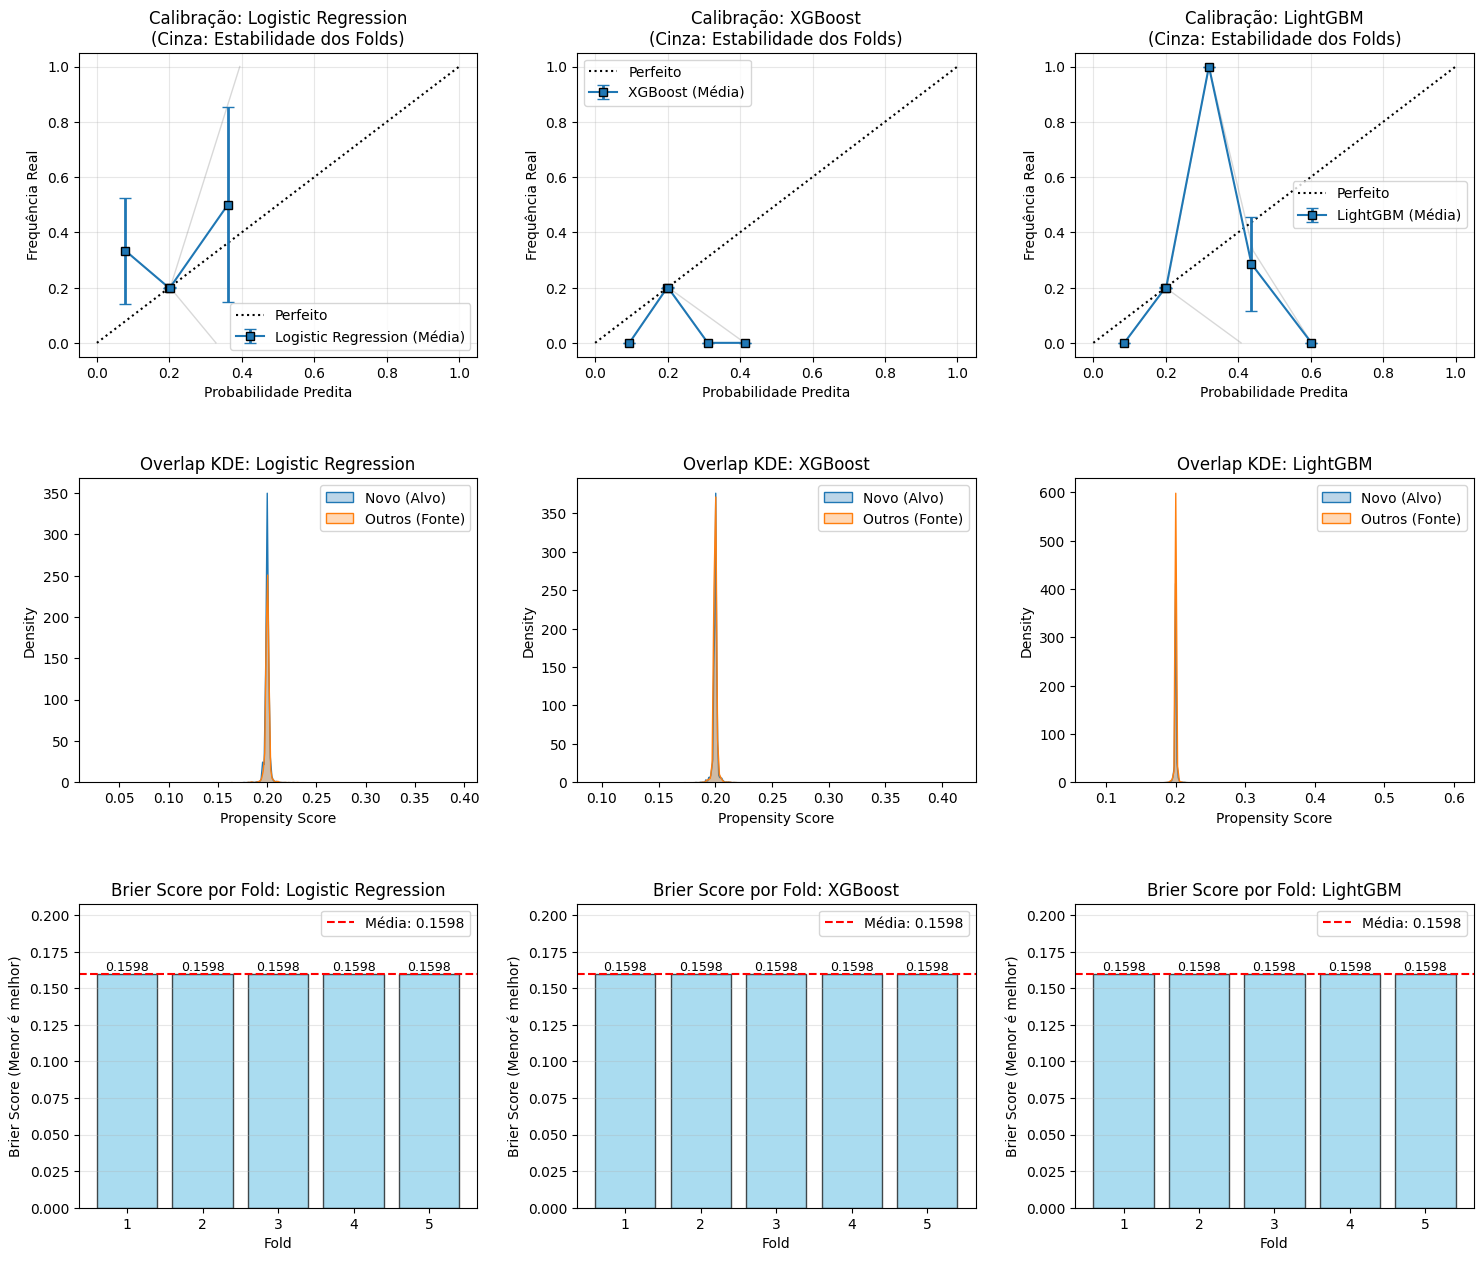

Este é um **Manual de Interpretação de Diagnósticos de Propensity Score Matching (PSM)**.

Ele foi desenhado para ser utilizado juntamente com o painel de gráficos gerado pelo seu código. O objetivo aqui não é apenas dizer "o que é", mas sim "como decidir" se o modelo está pronto para ser usado no pareamento (matching).

---

Este painel é composto por três camadas de verificação. Para aprovar um modelo para PSM, ele deve passar satisfatoriamente por todas as três.

##### 1. Gráficos de Calibração (Reliability Diagrams)
**Localização:** Linha superior.
**Pergunta:** *Quando o modelo diz que a chance é de 30%, é realmente 30%?*

###### O que observar:
*   **A Linha Diagonal Pontilhada (Ideal):** Representa a perfeição. Se o modelo prevê 0.2, na realidade 20% dos casos devem ser positivos.
*   **A Linha Azul (Média do Modelo):** É o comportamento real do seu modelo.
    *   **Acima da Diagonal:** O modelo é **pessimista** (subestima a probabilidade). Ele diz 20%, mas na verdade acontece 40%.
    *   **Abaixo da Diagonal:** O modelo é **otimista/superconfiante**. Ele diz 80%, mas só acontece 60%.
    *   **Formato em "S":** O modelo é indeciso no meio e superconfiante nas pontas (comum em modelos de árvore sem calibração).
*   **As Linhas Cinzas (Folds):** Representam a estabilidade do treinamento.
    *   **Cenário Bom:** As linhas cinzas estão todas "coladas" na linha azul. Isso indica que não importa como você divide os dados, o modelo aprende a mesma coisa (Baixa Variância).
    *   **Cenário Ruim:** As linhas cinzas estão espalhadas, uma subindo e outra descendo. Isso indica que o modelo é instável e muda drasticamente dependendo dos dados de treino. **Risco alto para PSM.**
*   **Barras de Erro (Error Bars):** Indicam a incerteza estatística.
    *   **Barra Curta:** Temos muitos dados neste intervalo (bin). A estimativa é confiável.
    *   **Barra Longa:** Temos poucos dados. O ponto pode estar longe da diagonal apenas por azar/ruído.
    *   **Cruzamento:** Se a barra de erro *cruza* a linha pontilhada, estatisticamente o modelo pode estar calibrado naquele ponto, mesmo que a média visual pareça fora.

###### 🚩 Red Flags (Sinais de Perigo):
*   **Curva "Quebrada" ou com poucos pontos:** (Como visto na sua imagem para XGBoost e LightGBM). Isso sugere que o modelo está prevendo apenas valores muito específicos (ex: todo mundo recebe score 0.2) e não há diversidade suficiente para preencher os 10 bins.
*   **Linha Azul longe da Diagonal:** O score de propensão está distorcido. Parear um indivíduo com score 0.4 (que na real é 0.2) com outro de 0.4 (que na real é 0.6) invalidará o estudo causal.

---

##### 2. Gráficos de Sobreposição (Overlap KDE)
**Localização:** Linha do meio.
**Pergunta:** *Existem "gêmeos" suficientes entre os grupos de Tratamento e Controle?*

###### O que observar:
Este gráfico mostra a distribuição dos scores (densidade) para os dois grupos.
*   **Área de Interseção (Overlap):** É a região onde as curvas Azul (Novo/Alvo) e Laranja (Outros/Fonte) se sobrepõem. O PSM só funciona matematicamente dentro dessa área.
*   **A Forma das Curvas:**
    *   **Separação Total (Ruim para PSM):** Se a curva azul está toda na direita (score 0.9) e a laranja na esquerda (score 0.1), o modelo é "perfeito demais". Ele descobriu uma variável que denuncia deterministicamente quem é o cliente. **Não há como fazer matching**, pois eles são incomparáveis.
    *   **Sobreposição Razoável (Ideal):** As curvas têm picos diferentes, mas compartilham uma boa área comum. Isso significa que existem clientes do grupo de controle que *se parecem* com os de tratamento.

###### ⚠️ Diagnóstico da sua Imagem Atual (Crítico):
Na imagem que você enviou, vemos um **Pico Único (Spike)** em torno de 0.20 para ambos os grupos em todos os modelos.
*   **Interpretação:** O modelo **não aprendeu nada** que diferencie os grupos. Ele está chutando a "taxa média" (prevalência) para todos os clientes.
*   **Consequência:** Todos os clientes têm o mesmo score. O matching será aleatório dentro desse grupo. Isso indica que as *features* (variáveis) escolhidas não têm poder preditivo sobre o target.

---

##### 3. Brier Score por Fold
**Localização:** Linha inferior.
**Pergunta:** *O modelo é consistente e melhor que um chute aleatório?*

###### O que observar:
O Brier Score mede a distância quadrática média entre a previsão e a realidade.
*   **Magnitude do Valor:**
    *   **0.00:** Perfeição (Impossível na vida real).
    *   **< 0.10:** Excelente calibração.
    *   **~ 0.15 a 0.20:** Aceitável (depende da dificuldade do problema).
    *   **> 0.25:** Pior que jogar uma moeda (se o dataset for balanceado).
*   **Linha Vermelha Tracejada (Média):** Dá a performance geral.
*   **Estabilidade das Barras:** As barras azuis devem ter alturas quase idênticas. Se uma barra for muito mais alta que as outras, aquele *fold* específico continha dados anômalos que quebraram o modelo.

###### 🧪 O "Teste do Chute Médio":
Se o Brier Score for igual a: $Proporção_{positivos} \times (1 - Proporção_{positivos})$, o modelo é inútil.
*   **Exemplo:** Se você tem 20% de clientes "Novos", o score de um modelo "burro" que chuta 0.20 para todo mundo será $0.2 \times 0.8 = 0.16$.
*   **Na sua imagem:** O score é **0.1598** em todos os modelos e folds. Isso confirma matematicamente o diagnóstico do KDE: **Seus modelos estão apenas chutando a média.** Eles não encontraram padrão nas variáveis `vol_recebimento_total`, `qtd_transacoes`, etc.

---

# 🚀 Resumo Prático: Como agir com base nesses gráficos?

Ao olhar para este painel, siga este fluxograma mental:

1.  **Olhe para o KDE (Meio):**
    *   *É um pico único fino?* **PARE.** O modelo não aprendeu nada. Adicione mais variáveis ou revise os dados. (Este é o caso atual).
    *   *São curvas totalmente separadas?* **PARE.** Remova variáveis que "vazam" a resposta (ex: ID, Data de cadastro recente).
    *   *Tem sobreposição distribuída?* Prossiga.

2.  **Olhe para a Calibração (Topo):**
    *   *A linha azul segue a diagonal?* Ótimo.
    *   *Tem erro padrão gigante cruzando a diagonal?* Cuidado, falta dado, mas pode ser aceitável se for honesto.
    *   *A curva é um "S" ou zigue-zague longe da diagonal?* Tente mudar o método de calibração (de Isotonic para Sigmoid) ou regularizar o modelo.

3.  **Olhe para o Brier Score (Fundo):**
    *   *As barras variam muito?* O modelo é instável. Aumente os dados ou reduza a complexidade do modelo.
    *   *O valor é baixo?* Confirma que o score de propensão é uma probabilidade confiável.

###### Veredito sobre a Imagem Enviada:
Os gráficos indicam que **o modelo atual não é válido para matching**.
*   **Motivo:** O Brier Score fixo em 0.1598 e o KDE em formato de agulha indicam que os modelos estão convergindo para uma constante (a média da população).
*   **Ação Recomendada:** As variáveis preditoras atuais (`vol_recebimento`, `qtd_transacoes`, etc.) provavelmente não distinguem os grupos 'novo' vs 'outro' nesse dataset simulado ou real. Você precisa de features que tenham correlação com o fato de ser um "Cliente Novo".

#### Deepdive nas seções do código:

Excelente escolha. Vamos mergulhar na seção **4. GERAÇÃO DE SCORES, CALIBRAÇÃO E PLOTAGEM**.

Essa é, sem dúvida, a parte mais crítica e sofisticada do seu *pipeline* antes do matching propriamente dito. Muitos cientistas de dados cometem o erro de pegar o `predict_proba` cru de um modelo (especialmente XGBoost ou Random Forest) e usá-lo direto no PSM. Você não fez isso, e vou explicar o porquê essa seção eleva o nível estatístico do seu projeto.

Vou dividir a explicação em **Conceitos Fundamentais** (o "porquê") e **Implementação Técnica** (o "como").

---

##### 1. O Conceito: Por que Calibrar?

Em Propensity Score Matching (PSM), o *score* não é apenas um número para ordenar quem é mais provável de ser "novo"; ele deve ser uma **probabilidade real**.

*   **O problema dos Modelos de Árvore (XGBoost/LightGBM):** Eles focam em separar classes (diminuir a impureza/entropia). Eles podem ser excelentes em dizer que o Cliente A é "Novo" e o Cliente B é "Outro", mas péssimos em dizer a probabilidade exata. Frequentemente, eles são "superconfiantes" (empurram probabilidades para 0 ou 1) ou distorcidos.
*   **O Impacto no PSM:** Se o score diz 0.8, deve significar que, de fato, 80% dos clientes com aquelas características são "novos". Se o score diz 0.8, mas na realidade apenas 40% são novos, a distância que você usará para parear os clientes está matematicamente errada. O matching será enviesado.

A **Calibração** ajusta a saída do modelo para que ela reflita a frequência real do evento.

---

##### 2. Análise Técnica Linha a Linha

Vamos dissecar o que seu código está fazendo para resolver isso.

###### A. A Escolha do Método (`calibration_method`)

```python
calibration_method = 'isotonic' if len(df) > 1000 else 'sigmoid'
```

*   **O que está acontecendo:** Você implementou uma regra de bolso clássica e correta.
*   **Sigmoid (Platt Scaling):** É uma regressão logística aplicada sobre o output do modelo. Assume uma forma de "S". É mais rígida (paramétrica), por isso funciona bem com **poucos dados** (evita overfitting na calibração).
*   **Isotonic (Regressão Isotônica):** Não assume forma (não paramétrica), apenas exige que a função seja monótona crescente (se o score sobe, a probabilidade sobe). Ela se ajusta melhor a distorções complexas, mas precisa de **muitos dados** (>1000 é um bom limiar) para não "decorar" o ruído.

###### B. A Estratégia de Validação Cruzada (`StratifiedKFold` e `cross_val_predict`)

Aqui está a robustez do seu código:

```python
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# ...
calibrated_model_cv = CalibratedClassifierCV(estimator=model, method=calibration_method, cv=3)
y_proba_cv = cross_val_predict(calibrated_model_cv, X, y, cv=cv, method='predict_proba', n_jobs=-1)
```

Temos uma estrutura **aninhada** (nested) aqui, o que é excelente:

1.  **O Loop Externo (`cross_val_predict` com `cv=5`):**
    *   O objetivo é gerar *propensity scores* para **todos** os indivíduos do seu dataset (`df`), mas garantindo que o score de um indivíduo *nunca* seja gerado por um modelo que treinou com ele. Isso simula um cenário "out-of-sample" limpo. Sem isso, teríamos *data leakage* e os scores seriam artificialmente perfeitos.

2.  **O Loop Interno (`CalibratedClassifierCV` com `cv=3`):**
    *   Dentro de cada fold do loop externo, o `CalibratedClassifierCV` pega os dados de treino e faz uma nova divisão interna (cv=3).
    *   Ele treina o modelo base (ex: XGBoost) em uma parte e usa a outra parte para ajustar a curva de calibração (aprender a transformar o score cru em probabilidade real).
    *   O resultado é um estimador que já sai calibrado.

**Resumo:** Você está garantindo que o score de propensão não sofra de overfitting nem no treinamento do classificador, nem no ajuste da calibração.

###### C. O Diagrama de Confiabilidade (`calibration_curve`)

```python
prob_true, prob_pred = calibration_curve(y, scores_results[name], n_bins=10)
# ... plot ...
ax_calib.plot([0, 1], [0, 1], "k:", label="Perfeito")
```

*   **Técnica (Binning):** A função divide as predições em 10 gavetas (bins). Ex: predições entre 0.0-0.1, 0.1-0.2, etc.
*   **Eixo X (`prob_pred`):** A média das probabilidades que o modelo previu naquele bin.
*   **Eixo Y (`prob_true`):** A fração real de casos positivos ("segmento_novo" = 1) naquele bin.
*   **Interpretação:**
    *   Se o ponto está na linha diagonal pontilhada: O modelo disse 0.3 e 30% eram positivos. **Perfeito.**
    *   Se a curva faz um "S": O modelo é subconfiante nos extremos.
    *   Se a curva está acima da diagonal: O modelo subestima a probabilidade (pessimista).
    *   Se a curva está abaixo da diagonal: O modelo superestima a probabilidade (otimista/superconfiante).

###### D. O Gráfico de Sobreposição (Overlap) com KDE

```python
sns.kdeplot(scores_results[name][y==1], label='Novo (Alvo)', ...)
sns.kdeplot(scores_results[name][y==0], label='Outros (Fonte)', ...)
```

*   **Conceito de Suporte Comum (Common Support):** Para o PSM funcionar, precisa haver uma região onde as distribuições de probabilidade dos dois grupos se sobreponham.
*   **O que observar:**
    *   Se as curvas (azul e laranja, por exemplo) estiverem totalmente separadas (ex: Tratados em 0.9 e Controle em 0.1), **o PSM falhará**. Não existe "gêmeo" comparável. Isso significa que as características dos grupos são tão diferentes que eles são incomparáveis.
    *   Você quer ver uma boa área de intersecção sob as curvas. É nessa área que os *matches* de qualidade acontecerão.

---

##### 3. Conclusão sobre esta seção

Esta seção é o "controle de qualidade" do seu Propensity Score.

1.  Se o gráfico de calibração mostrar uma curva muito distante da diagonal, aquele modelo (Logistic, XGB ou LGBM) não é confiável para gerar a distância de matching, mesmo que tenha acurácia alta.
2.  Se o gráfico de KDE não mostrar sobreposição, você precisaria voltar à etapa 2 (features) e remover variáveis que "denunciam" perfeitamente quem é o tratamento (variáveis preditoras perfeitas matam o PSM).

**Em resumo:** O código está tecnicamente rigoroso. O uso de `CalibratedClassifierCV` dentro de um fluxo de validação cruzada para gerar os scores finais demonstra maturidade no manuseio de modelos probabilísticos para inferência causal.

#### Entendendo Erro Padrão e Brier Score

Esta é uma pergunta fundamental. Muitas vezes, em Ciência de Dados, ficamos viciados em métricas de classificação pura (Acurácia, F1-Score, AUC), mas quando entramos no território de **Inferência Causal e PSM**, precisamos sair da mentalidade de "Classificação" e entrar na mentalidade de **Estimação de Probabilidade**.

Para que o PSM funcione, o *score* (0.7, por exemplo) tem que significar matematicamente 70% de chance. Se o modelo diz 0.7 com base em 3 exemplos, é muito diferente de dizer 0.7 com base em 3.000 exemplos.

Vamos detalhar cada um dos conceitos que você pediu.

---

##### 1. O Erro Padrão (Standard Error - SE) nos Bins

O **Erro Padrão** que adicionamos ao gráfico de calibração é a medida da nossa **incerteza** sobre a probabilidade real dentro daquele "bin" (intervalo).

###### A Intuição Estatística
Imagine que dividimos nossos dados e pegamos apenas o bin onde o modelo previu probabilidades entre **0.2 e 0.3**. Digamos que caíram 100 clientes nesse bin.
Desses 100 clientes, verificamos a realidade ($y_{true}$) e vimos que 25 deles eram realmente "Novos" (Sucesso/1).

*   **Frequência Observada (Média Real):** $p = \frac{25}{100} = 0.25$.
*   O ponto no gráfico será plotado em $y=0.25$.

**A pergunta estatística é:** Se tivéssemos pego *outros* 100 clientes com as mesmas características, a frequência seria exatamente 0.25 de novo? Provavelmente não. Seria 0.22, 0.28...

O **Erro Padrão** nos diz o quanto essa média (0.25) "dança" ou varia se repetíssemos o experimento infinitas vezes.

###### A Matemática (Rigorosa)
Dentro de um bin, cada observação é um evento binário (0 ou 1). Estatisticamente, isso é modelado por uma **Distribuição de Bernoulli**.

1.  **Variância de uma Bernoulli:** Para um único evento com probabilidade $p$, a variância ($\sigma^2$) é:
    $$ \sigma^2 = p \cdot (1 - p) $$
    *Note que a incerteza é máxima quando $p=0.5$ e mínima quando $p=0$ ou $p=1$.*

2.  **Variância da Média Amostral:** Quando tiramos a média de $n$ observações independentes, a variância da média cai proporcionalmente ao tamanho da amostra ($n$):
    $$ Var(\bar{p}) = \frac{\sigma^2}{n} = \frac{p \cdot (1 - p)}{n} $$

3.  **Erro Padrão (Standard Error):** O erro padrão é simplesmente o desvio padrão (raiz quadrada da variância) dessa média amostral:
    $$ SE = \sqrt{\frac{p \cdot (1 - p)}{n}} $$

###### O que isso significa no seu gráfico?
As barras verticais (Error Bars) que plotamos representam, geralmente, $\pm 1 SE$ ou $\pm 1.96 SE$ (para um Intervalo de Confiança de 95%).

*   **Barra Pequena:** O $n$ daquele bin é gigante. O modelo disse que a probabilidade é 0.25 e temos certeza estatística que é 0.25.
*   **Barra Grande:** O $n$ é pequeno. O modelo disse 0.25, mas estatisticamente o valor real poderia ser 0.10 ou 0.40. **Não confie cegamente nesse ponto.**

**No contexto do seu código:** Se a barra de erro cruzar a linha diagonal pontilhada ("Perfeito"), significa que a diferença entre a predição e a realidade **não é estatisticamente significante**. Ou seja, mesmo que visualmente pareça fora, estatisticamente o modelo pode estar calibrado.

---

##### 2. O Brier Score

O **Brier Score** é, em essência, o **Mean Squared Error (MSE)** aplicado a probabilidades.

Enquanto a Acurácia olha se você acertou a classe (0 ou 1), o Brier Score olha o **quão perto a sua probabilidade passou da realidade**.

###### A Fórmula
$$ BS = \frac{1}{N} \sum_{i=1}^{N} (f_i - o_i)^2 $$

Onde:
*   $f_i$ é a probabilidade prevista (forecast), ex: 0.9.
*   $o_i$ é o resultado observado (outcome), ex: 1.0 (aconteceu) ou 0.0 (não aconteceu).
*   $N$ é o número total de observações.

###### Exemplos Práticos
Vamos supor que o evento real aconteceu ($o_i = 1$).

1.  **Modelo Confinate e Correto:**
    *   Previu 0.95.
    *   Erro: $(0.95 - 1)^2 = (-0.05)^2 = 0.0025$.
    *   **Brier Score minúsculo (Excelente).**

2.  **Modelo Hesitante (Em cima do muro):**
    *   Previu 0.50.
    *   Erro: $(0.50 - 1)^2 = (-0.50)^2 = 0.25$.
    *   **Brier Score médio (Ruim, equivale a chutar moeda).**

3.  **Modelo Superconfiante e Errado:**
    *   Previu 0.10 (tinha certeza que NÃO ia acontecer).
    *   Erro: $(0.10 - 1)^2 = (-0.90)^2 = 0.81$.
    *   **Brier Score gigante (Péssimo).**

###### Utilidade no seu Projeto de PSM
Para Propensity Score Matching, o Brier Score é mais importante que o AUC ou Acurácia. Por quê?

*   O **AUC** apenas mede a **Ordem**. Se o modelo der score 0.51 para todos os positivos e 0.49 para todos os negativos, o AUC será 1.0 (Perfeito), mas as probabilidades estão horríveis (tudo perto de 0.5).
*   O **Brier Score** penaliza a **Calibração**. Se o modelo diz 0.9, tem que acontecer 90% das vezes. O Brier Score captura tanto a capacidade de discriminação (separar 0 de 1) quanto a confiabilidade da probabilidade.

**Resumo da Leitura do Brier Score:**
*   **0.0:** Perfeição Divina (o modelo é clarividente).
*   **~0.05 a 0.15:** Modelos muito bons e bem calibrados.
*   **0.25:** Chute aleatório (se as classes forem 50/50). O modelo não aprendeu nada.
*   **> 0.25:** O modelo está ativamente atrapalhando ou está invertido.

Ao monitorar o Brier Score de cada *fold* no seu código, se você vir valores pulando de 0.10 para 0.20 entre os folds, você sabe que seu modelo é instável e o Score de Propensão gerado não é confiável para parear empresas.